 # Advanced Machine Learning - programming assignment 2

*Due: Sunday December 19*

**Please fill in:**
* Grady, Idan (7304447)
* Kirschstein Schäfer, Oscar Alexander (1164783)

### Further instructions:
* Make sure your code is properly commented.
* You can find the required python packages in requirements.txt (Keep in mind, the grader most likely won't install additional packages. Try to stick with the standard library and the packages listed.)
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (submitter_collaborator.ipynb)

 ## Reinforcement learning with function approximation

In this assignment, you'll design your own agent to complete an episodic MDP task following the gym framework. The agent will be looking at a small part of the UU logo, and have to decide which of the four compass directions (i.e. left, right, up, down) to move in. The learning task is to find the goal in the center as soon as possible.

The learning objectives of this assignment are:

- Implement two versions of the agent using Semi-gradient SARSA and Q-learning algorithms with a linear approximation function,
- Demonstrate the difference between on-policy and off-policy RL methods,
- Learn to integrate the approximation function with Tabular RL methods,
- Play with the parameters discounted factor $\gamma$ and stepsize $\alpha$ and understand their influence on the learning procedure. 


### 1. Let's start with setting up the enviroment.

The following code defines various aspects of the environment.

In [1]:
import itertools as it
from abc import ABC, abstractmethod
from enum import IntEnum
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from IPython import display
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from scipy import stats
from tqdm.notebook import tqdm  # For progress bars

# Extra used Libraries
from pickle import dump, load

In [2]:
# %matplotlib inline
# Constants defining the environment
GOAL = (140, 120)
CENTER = (132, 132)
AVG_MOVEMENT_SIZE = 24
ACCEPTABLE_DISTANCE_TO_GOAL = (AVG_MOVEMENT_SIZE // 2) + 1
RADIUS = 72
WINDOW_SIZE = 28
TIME_LIMIT = 200
TIMEOUT_REWARD = -100.0
MOVE_REWARD = -1
INVALID_MOVE_REWARD = -5


# This is for type inference
State = Tuple[int, int]


# Action space
class Actions(IntEnum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3


# Boundaries
class Boundary(IntEnum):
    WEST = CENTER[0] - RADIUS
    EAST = CENTER[0] + RADIUS
    NORTH = CENTER[1] - RADIUS
    SOUTH = CENTER[1] + RADIUS


class MovementArea(IntEnum):
    WEST = Boundary.WEST - (WINDOW_SIZE // 2)
    EAST = Boundary.EAST + (WINDOW_SIZE // 2)
    NORTH = Boundary.NORTH - (WINDOW_SIZE // 2)
    SOUTH = Boundary.SOUTH + (WINDOW_SIZE // 2)


# Image
ORIGINAL_IMAGE = plt.imread("UU_LOGO.png")
# Convert to one color channel (using only the red channel), with white background
IMAGE = ORIGINAL_IMAGE[:, :, 0] * ORIGINAL_IMAGE[:, :, 3] + (1.0 - ORIGINAL_IMAGE[:, :, 3])


# Get a "camera view" at the position indicated by state
# Use reshape=True to format the output as a data point for the neural network
def get_window(state: State, reshape=False) -> np.ndarray:
    # When indexing the image as an array, switch the coordinates: im[state[1], state[0]]
    window = IMAGE[(state[1] - 14):(state[1] + 14), (state[0] - 14):(state[0] + 14)]
    if reshape:
        return np.reshape(window, (1, 28, 28, 1))
    return window


# Is the state close enough to the goal to be considered a success?
# There is a margin for error, so that the agent can't jump over the goal
def is_goal_reached(state: State) -> bool:
    if np.amax(np.abs(np.asarray(state) - np.asarray(GOAL))) <= AVG_MOVEMENT_SIZE / 2 + 1:
        return True
    return False


# This is a helper function to render a run
def updatefig(j, images, imgplot, text_act_plot, text_reward_plot):
    # set the data in the axesimage object
    img, time_point, from_state, to_state, act, current_reward = images[min(len(images), j)]
    imgplot.set_data(img)
    text_act_plot.set_text(f"Time step: {time_point} - Action: {act}\nState: {from_state} -> {to_state}")
    text_reward_plot.set_text(f"Current total reward: {current_reward}")
    # return the artists set
    return [imgplot, text_act_plot]


# This will render a run of a full epoch
# The function needs a list of tuples containing an image array, a State, the performed action
def render_epoch(animation_data: List[Tuple[np.ndarray, State, Actions]], interval=100, blit=True, **kwargs):
    if not len(animation_data):
        return f"No images in the list"
    fig, ax = plt.subplots()
    imgplot = ax.imshow(np.zeros_like(animation_data[0][0]))
    text_act_plot = ax.set_title("", color="red", fontweight="extra bold", loc="left")
    text_reward_plot = ax.text(5, 255, "", color="red", fontweight="extra bold")
    params = [animation_data, imgplot, text_act_plot, text_reward_plot]
    ani = FuncAnimation(fig,
                        updatefig,
                        fargs=params,
                        frames=len(animation_data),
                        interval=interval,
                        blit=blit,
                        **kwargs)
    animation = HTML(ani.to_jshtml())
    plt.close()
    return display.display(animation)



 The following 2 images show:
 * The original image, with a red dot marking the goal and a red rectangle marking the area where the center of agent must remain. A movement that would take the agent outside this rectangle, places him at the boundary instead. The blue rectangle represents the area the agent is able to see, which is slightly bigger than the area in which it can move.
 * What the agent sees if s/he is exactly at the goal.

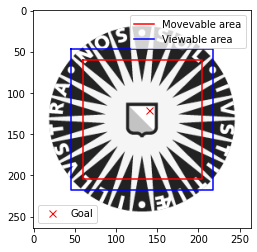

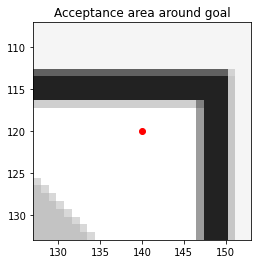

In [3]:
plt.imshow(IMAGE[:, :], cmap='gray', vmin=0, vmax=1.0)
# Plotting uses reversed y-axis now: larger y values are further down
goal_container = plt.plot(GOAL[0], GOAL[1], 'rx', markersize="7")
legend2 = plt.legend(goal_container, ["Goal"], loc=3)

plt.plot([Boundary.WEST, Boundary.WEST, Boundary.EAST, Boundary.EAST, Boundary.WEST],
         [Boundary.NORTH, Boundary.SOUTH, Boundary.SOUTH, Boundary.NORTH, Boundary.NORTH],
         'r-',
         label="Movevable area")
plt.plot([MovementArea.WEST, MovementArea.WEST, MovementArea.EAST, MovementArea.EAST, MovementArea.WEST],
         [MovementArea.NORTH, MovementArea.SOUTH, MovementArea.SOUTH, MovementArea.NORTH, MovementArea.NORTH],
         'b-',
         label="Viewable area")

plt.legend()
plt.gca().add_artist(legend2)
plt.show()

# window around goal
img_container = plt.imshow(get_window(GOAL),
                           cmap='gray',
                           vmin=0,
                           vmax=1.0,
                           extent=(GOAL[0] - ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[0] + ACCEPTABLE_DISTANCE_TO_GOAL,
                                   GOAL[1] + ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[1] - ACCEPTABLE_DISTANCE_TO_GOAL))
plt.plot(GOAL[0], GOAL[1], 'ro', linewidth=1)
plt.title("Acceptance area around goal")
plt.show()



 The following functions complete the definition of the environment. The agent's movements always go in the intended direction, but the distance travelled has a small random component. Besides by reaching the goal, the episode also terminates after TIME_LIMIT (200) steps; at that point, the agent gets a negative reward TIMEOUT_REWARD.

In [4]:
class Environment(gym.Env):
    metadata = {'render.modes': ['human', 'rgba_array']}
    bx = np.array([MovementArea.WEST, MovementArea.WEST, MovementArea.EAST, MovementArea.EAST, MovementArea.WEST])
    by = np.array([MovementArea.NORTH, MovementArea.SOUTH, MovementArea.SOUTH, MovementArea.NORTH, MovementArea.NORTH])

    def __init__(self):
        self.num_actions = Actions
        self.action_space = spaces.Discrete(len(self.num_actions))
        self.observation_space = spaces.Discrete(1)
        self.display = None
        self.img, self.img_container = Environment._init_visual_area(IMAGE)
        self.time = 0

    def seed(self, seed=None) -> int:
        np.random.seed(seed)
        return seed

    def step(self, action: Actions):
        assert self.action_space.contains(action)
        (x, y), was_invalid = self._validate_state(self._move(self.state, action))

        self.state = (x, y)
        reward = MOVE_REWARD if not was_invalid else INVALID_MOVE_REWARD
        reward = TIMEOUT_REWARD if self.time >= TIME_LIMIT else reward
        reward = self.time * reward
        done = is_goal_reached(self.state) or self.time >= TIME_LIMIT
        self.time += 1
        return self.state, reward, done, {}

    def reset(self, state: State = None) -> State:
        self.state = self.starting_state() if not state else state
        self.time = 0
        return self.state

    # returns the current environment situation
    def render(self, mode='rgba_array'):
        curr_img = np.array(self.img_container.get_array())
        x, y = self.state
        scaler = 4
        w, e, n, s = x - scaler, x + scaler, y - scaler, y + scaler
        curr_img[n:s, w:e, 0] = 255
        curr_img[n:s, w:e, 1] = 0
        curr_img[n:s, w:e, 2] = 255
        curr_img[n:s, w:e, 3] = 255
        cropped_img = curr_img  # Just for debugging purposes
        if mode == 'rgba_array':
            plt.close()
            return cropped_img  # return RGB frame suitable for video
        if mode == 'human':
            container = plt.imshow(curr_img)
            ax = container.axes
            ax.set_xlim(Boundary.WEST, Boundary.EAST, auto=None)
            ax.set_ylim(Boundary.SOUTH, Boundary.NORTH, auto=None)
            return container
        else:
            raise Exception(f"Please specify either 'rgba_array' or 'human' as mode parameter!")

    # Return a randomly chosen non-terminal state as starting state
    def starting_state(self) -> State:
        while True:
            state = (
                np.random.randint(Boundary.WEST, Boundary.EAST + 1),
                np.random.randint(Boundary.NORTH, Boundary.SOUTH + 1),
            )
            if not is_goal_reached(state):
                return state

    @staticmethod
    def _move(state: State, action: Actions) -> State:
        x, y = state
        if action == Actions.NORTH:
            y -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.SOUTH:
            y += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.WEST:
            x -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.EAST:
            x += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        return x, y

    @staticmethod
    def _validate_state(state: State) -> Tuple[State, bool]:
        x, y = state
        is_invalid = False
        if y < Boundary.NORTH:
            is_invalid = True
            y = int(Boundary.NORTH)
        if y > Boundary.SOUTH:
            is_invalid = True
            y = int(Boundary.SOUTH)
        if x < Boundary.WEST:
            is_invalid = True
            x = int(Boundary.WEST)
        if x > Boundary.EAST:
            is_invalid = True
            x = int(Boundary.EAST)
        return (x, y), is_invalid

    @staticmethod
    def _init_visual_area(img) -> np.ndarray:
        x, y = img.shape
        my_dpi = 80
        fig = Figure(figsize=(y / my_dpi, x / my_dpi), dpi=my_dpi)
        canvas = FigureCanvasAgg(fig)
        ax = fig.gca()

        ax.plot(GOAL[0], GOAL[1], 'ro', linewidth=5)
        ax.plot(Environment.bx, Environment.by, 'b-')
        img_container = ax.imshow(img[:, :], cmap='gray', vmin=0, vmax=1.0)
        ax.axis('off')
        fig.tight_layout()
        canvas.draw()  # draw the canvas, cache the renderer
        s, (width, height) = canvas.print_to_buffer()
        image = np.frombuffer(s, np.uint8).reshape((height, width, 4))
        img_container.set_data(image)
        plt.close()
        return image, img_container



### 2. Implement your agent

Next comes your part. The following class is responsible for the agent's behavior. The select_action function should implement the epsilon-greedy policy, and return an action chosen according to that policy. **Please fill in the missing codes in select_action function (1.5 points).** 

 Remark: This is an abstract class.
 Hence, its sole purpose is creating subclasses from it, which is also the reason it cannot be instantiated.
 The following subsequent subclasses will provide a specific implementation for the methods that are missing here.
 Therefore, you can ignore the functions that are not implemented. This is just a common way to make sure that all subclasses behave similarly.

In [5]:
class Agent(ABC):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        # set up the value of epsilon
        self.alpha = alpha  # learning rate or step size
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.hist = []

    # Choose action at state based on epsilon-greedy policy and valueFunction
    def select_action(self, state: Tuple[int, int], is_greedy: bool = True) -> int:

        # Get random number to know i the agent should be greedy or explore
        probability = np.random.rand()

        # Get all the values per action of that state
        vals = self.values(state)

        if is_greedy or probability > self.epsilon: # Greedy
            # Argmax action from action-value
            best_actions = [i for i, x in enumerate(vals) if x == self.state_value(state)]
        else: # Exploration
            best_actions = range(len(vals))

        self.hist.append(vals)
        return int(np.random.choice(best_actions))

    # Return estimated action value of given state and action
    @abstractmethod
    def value(self, state: State, action: Actions) -> float:
        pass

    # Return vector of estimated action values of given state, for each action
    @abstractmethod
    def values(self, state: State) -> np.ndarray:
        pass

    # learn with given state, action and target
    @abstractmethod
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        pass

    # Return estimated state value, based on the estimated action values
    def state_value(self, state):
        return np.max(self.values(state))

    # Plot the state value estimates. Use a larger stride for lower resolution.
    def plot_state_values(self, stride=1):
        self.v = np.zeros(
            ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
        for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
            for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
                self.v[i, j] = self.state_value((x, y))

        plt.imshow(self.v)
        plt.colorbar()
        return plt.show()

    def plot_q_values(self, skip=1):
        return pd.DataFrame(self.hist[::skip]).plot()



 The next classes are two agents using either episodic semi-gradient Q-learning and episodic semi-gradient SARSA algorithm to estimate the value function. Both agents use the same linear function approximation method with tile coding. **Implement the `learn` function according to the update rule for the respective algorithm (1 point for each)**. 
 
 REMARK: Both agents use the same tile coding. This method helps splitting the state-space into discrete chunks. Each chunk is associated with one weight.

## Pseudocode
### Tabular Sarsa & Q-learning
<!-- ![](tabular_sarsa_qlearning.png) -->
<img src="tabular_sarsa_qlearning.png" alt="drawing" width="700"/>

### Sarsa with function approximation
![](sarsa_pseudo.png)

### Q-learning from function approximation
From what was said in the lectures, the difference is mainly in the weight update statement. So the algorithm would look like this:  
&ensp;  
Input: a differentiable action-value function parameterization $\hat{q} : S\times A\times \mathbb{R}^d \to R$  
Algorithm parameters: step size $\alpha > 0$, small $\varepsilon > 0$   
Initialize value-function weights **w** $\in \mathbb{R}^d$ arbitrarily (e.g., **w = 0**)  
Loop for each *episode*:  
&ensp;&ensp;$S \gets$ initial state  
&ensp;&ensp;Loop for each *step* of *episode*:  
&ensp;&ensp;&ensp;&ensp;Choose A as a function of $\hat q(S, \cdot ,w) (\mathsf{e.g.}, \varepsilon-greedy)$  
&ensp;&ensp;&ensp;&ensp;Take action $A$, observe $R, S'$  
&ensp;&ensp;&ensp;&ensp;If $S'$ is terminal:  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$w \gets w + \alpha[R - \hat q(S,A,w)]\nabla\hat q(S,A,w)$  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;Go to next episode   
&ensp;&ensp;&ensp;&ensp;$w \gets w + \alpha[R + \gamma\max_a\hat q(S',a,w) - \hat q(S,A,w)]\nabla\hat q(S,A,w)$                   **IMPORTANT CHANGE**  
&ensp;&ensp;&ensp;&ensp;$S \gets S'$  
&ensp;&ensp;&ensp;&ensp;$A \gets A'$  

In [6]:
# This class handles the function approximation, with several methods to query and update it. 
# A linear approximation function is used, making the computation much faster.
class QAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        super().__init__(alpha, gamma, epsilon)
        # Use a tile coding with only a single tiling (i.e. state aggregation):
        # a grid of square tiles
        self.tile_size = 16
        self.W_SHAPE = ((Boundary.SOUTH - Boundary.NORTH + self.tile_size) // self.tile_size,
                        (Boundary.EAST - Boundary.WEST + self.tile_size) // self.tile_size, 4)
        self.w = np.zeros(self.W_SHAPE)

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size,
                      action]

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, :]

    # learn with given state, action and target
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):

        #getting the next values
        q_current = self.value(state,action)
        #update based on the max value in the current state action pair.
        q_next = self.state_value(next_state)

        # upddate the inner step
        inner = (reward + ((self.gamma* q_next) - q_current))

        #Update for the parameters
        self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, action] += self.alpha * (inner)




In [7]:
class SARSAAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        super().__init__(alpha, gamma, epsilon)

        # Use a tile coding with only a single tiling (i.e. state aggregation):
        # a grid of square tiles
        self.tile_size = 16
        self.W_SHAPE = ((Boundary.SOUTH - Boundary.NORTH + self.tile_size) // self.tile_size,
                        (Boundary.EAST - Boundary.WEST + self.tile_size) // self.tile_size, 4)
        self.w = np.zeros(self.W_SHAPE)

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size,
                      action]

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, :]

    # learn with given state, action and target
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        
        #actions allocation
        q_current = self.value(state,action)
        next_action = self.select_action(next_state, is_greedy=False) # epsilon greedy
        q_next = self.value(next_state,next_action)
        
        # This is wrong because you are doing an unjustified +1 update to the w
        inner = (reward + ((self.gamma* q_next) - q_current))

        #Update for W in the current loc
        self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, action] += self.alpha * (inner)
       
        #return next action 
        return next_action


 The following function handles the interaction between agent and environment for a single episode. By passing the same value_function object in multiple calls to this function, the agent can learn from a sequence of such interactions.

 **Please fill in the missing parts (1 point).** 

In [8]:
""" 
env: Environment in which the agent is supposed to run 

agent: agent to learn
initital state: Starting state for the environment
is_learning: should the value function be updated during the simulation?
is_rendering: should the run be recorded? (Takes some time to compute)

return : current_state, total_reward, animation_data
"""

def run_episode(env: Environment,
                agent: Agent,
                initial_state: State,
                is_learning: bool = True,
                is_rendering: bool = False) -> Tuple[State, float]:
    # Initialize reward for episode
    total_reward = 0.0
    # Initialize
    is_greedy = not is_learning
    # Get initial action
    current_state = initial_state
    current_action = agent.select_action(initial_state, is_greedy=is_greedy)

    # Track the rendering
    animation_data = []
    animation_data.append((env.render(), env.time, None, current_state, None, 0))
    # Initialize variables
    next_state = None
    done = False

    while not done:
        #perform a step 
        next_state, reward, done, _ = env.step(current_action)

        total_reward += reward
        #check we render
        if is_rendering:
            curr_img = env.render()
            animation_data.append((curr_img, env.time, current_state, next_state, current_action, total_reward))
        
        #check if we learn. If not ==> Greedy policy
        if is_learning: 
            #Qlearn does not return the next state
            if isinstance(agent, QAgent):
                agent.learn(current_state,current_action,next_state,reward)
                next_action = agent.select_action(next_state, is_greedy=is_learning)
            #if not Q leaerning
            else:
                next_action = agent.learn(current_state,current_action,next_state,reward)
        else: # Greedy action
            next_action = agent.select_action(next_state, is_greedy=True)
        
        #Update for the next state and action
        current_action = next_action
        current_state = next_state
    #Return Values
    return current_state, total_reward, animation_data


 To help understand your agent, you can render the agent's performance by setting render to True and running the `run_epoch` function. 
 
 There are some helper functions. They might help you implement the agent correctly. 
 * `agent.plot_state_values` shows you how the agent values different states
 * `agent.plot_q_values` shows the q_values that the agent had over the course of his life time. (That could be a lot. There's a skip parameter to reduce the amount of data points)

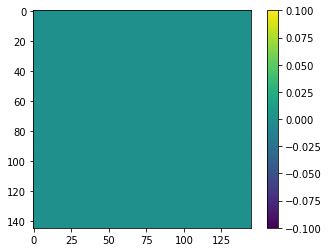

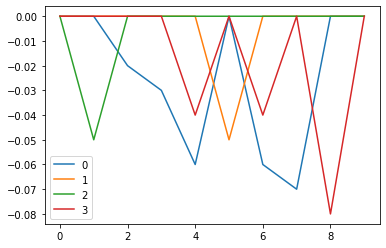

In [9]:
""" 
Code to train a Q-Learning agent for one single episode
"""

env = Environment()
epsilon = 0.01
gamma = .7
alpha = 1e-2
agent = QAgent(alpha, gamma, epsilon)
start_state = env.reset()
end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=True)
agent.plot_state_values()
agent.plot_q_values(skip=1)
render_epoch(animation_data, interval=100)

### 3. Run the simulation, play with parameters and analyse results

 Now it's time to train both algorithms/agents on the environment. 
 
 In the simulations, please plot the measure of each algorithm's performance as a function of the episode (i.e. the sum of all immediate rewards received in each episode). You shall play with a few combinations of two parameters discounted factor $\gamma$ and stepsize $\alpha$ (at least two variables for each parameter). During the experiments, keep $\epsilon$ fixed at $0.01$. A reasonable starting point for $\alpha$ is 1e-2. 
 
 REMARK: You can save the parameters and update-to-date Q table of each agent, so that you can still test their performance later. (You can achieve this by keeping the object.)
 

**3.1 Please submit your code as well as the plots presenting compariable performance of the different combinations of parameters for every algorithms (2 points)**. 

REMARK: For a decent comparison all agents should be plotted on the same axis bounds.

### Question 3.1 Code

In [10]:
""" 
In the below cell there is the loop across all wished configuration for further analysis.

Hyper params:
Alphas
Gammas
run
episodes

Output list contains all the saved results
For Every run:
append: [agent, mean rewards_per_run, alpha, gamma]
"""

#Bool to run this cell or not. The puprose is to make testing quicker
run = True

if run:
    env = Environment()

    epsilon = 1e-2
    alphas = np.linspace(0.1,0.3,3)
    gammas = np.linspace(0.4,0.7,3)

#Types of agent ==> Class
    agent_types = [SARSAAgent, QAgent]

#Output list
    outputs = []

    total_agents = len(gammas)*len(alphas)*len(agent_types)
    ags=0

#Loop through all the different combinations of parameters
    for gamma in gammas:
        for alpha in alphas:
            for agent_type in agent_types:
                rewards_per_run = []
                steps_per_run = []
                for run in range(10):
                    agent = agent_type(alpha, gamma, epsilon)
                    #reward list for the current run
                    reward_per_episode = []
                    steps_per_episode = []
                    for episode in range(1000):
                        #initialize the environment for the episode
                        start_state = env.reset()
                        end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=False)
                        #append the rewards for this episode
                        reward_per_episode.append(total_reward)
                        steps_per_episode.append(env.time)
                    #append the rewards for the whole run
                    rewards_per_run.append(reward_per_episode)
                    steps_per_run.append(steps_per_episode)

                #append the information for the whole run
                outputs.append((agent, np.mean(rewards_per_run, axis=0), alpha, gamma, np.mean(steps_per_run, axis=0)))
                ags+=1
                #print
                print(f"\r{ags}/{total_agents} Agents trained", end="")


18/18 Agents trained

In [11]:
""" 
Load/ Save execution files in case is needed
"""
# !!!!!!!!
# TODO: Mention that they are able to load the run with this file
# !!!!!!!! 
run_data_file = "outputs.pkl"
saved = True
load_ = False

if saved:
    dump(outputs, open(run_data_file, "wb"))
if load_:
    outputs = load(open(run_data_file, "rb"))

' \nLoad/ Save execution files in case is needed\n'

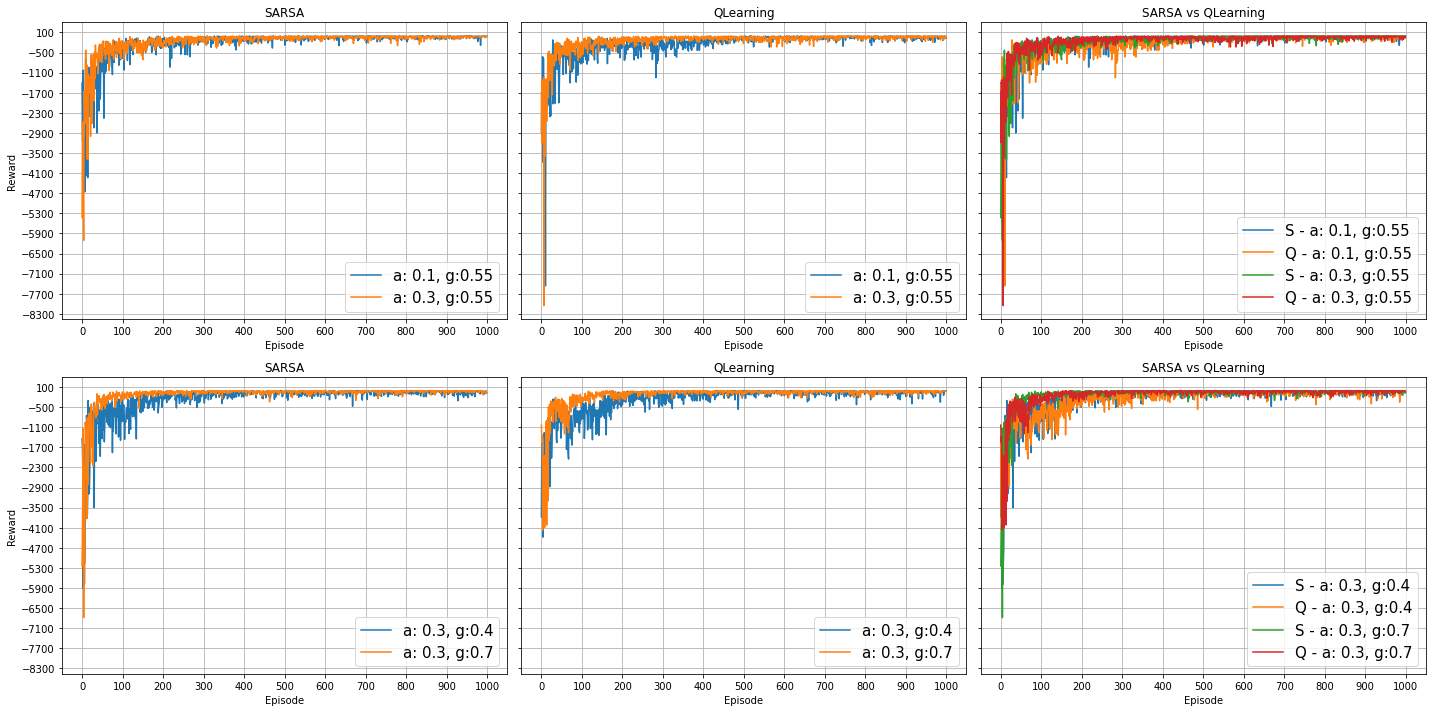

In [12]:
""" 
Initial Plots.
These plots are a comparison between Q learning and Sarsa over multiple parameter configurations
Experimented parameters:
- Gamma: [0.4, 0.55, 0.7]
- Alphas: [0.1, 0.2, 0.3]

We picked only a small amount for further analysis
"""
# Plot code
df = pd.DataFrame(outputs, columns =["Models", "Values", "Alpha", "Gamma", "Steps"])

#chosen values      [[gammas], [Alphas]]
row_values = [[0.1,0.3,0.55], [0.3,0.4,0.7]]

#subplots
fig, ax = plt.subplots(2,3,figsize=(20,10), sharey=True)

for axis, values in zip(ax, row_values):
    plot_df = df[df.Alpha.isin(values) & df.Gamma.isin(values)]
    for i, row in plot_df.iterrows():
    #plot Sarsa
        if isinstance(row.Models, SARSAAgent):
            axis[0].plot(row.Values, label= f"a: {row.Alpha}, g:{row.Gamma}")
            axis[0].set_title("SARSA")
    #plot QAgent
        elif isinstance(row.Models, QAgent):
            axis[1].plot(row.Values, label= f"a: {row.Alpha}, g:{row.Gamma}")
            axis[1].set_title("QLearning")
        axis[2].plot(row.Values, label=f"{row.Models.__class__.__name__[0]} - a: {row.Alpha}, g:{row.Gamma}")
    #plot the mix
        axis[2].set_title("SARSA vs QLearning")
        for a in axis:
            a.grid()
    #subplot designs
for axis in ax:
    for idx,a in enumerate(axis):
        if idx in [0,3]:a.set_ylabel("Reward")
        a.grid()
        start, end = a.get_xlim()
        a.xaxis.set_ticks(np.arange(start+50, end, 100))
        start, end = a.get_ylim()
        a.yaxis.set_ticks(np.arange(start+160, end, 600))
        a.legend(loc= 4, prop={'size': 15})
        a.set_xlabel("Episode")

#plot
plt.tight_layout()
plt.savefig("./comparison_plots_reward_per_epi.jpg")


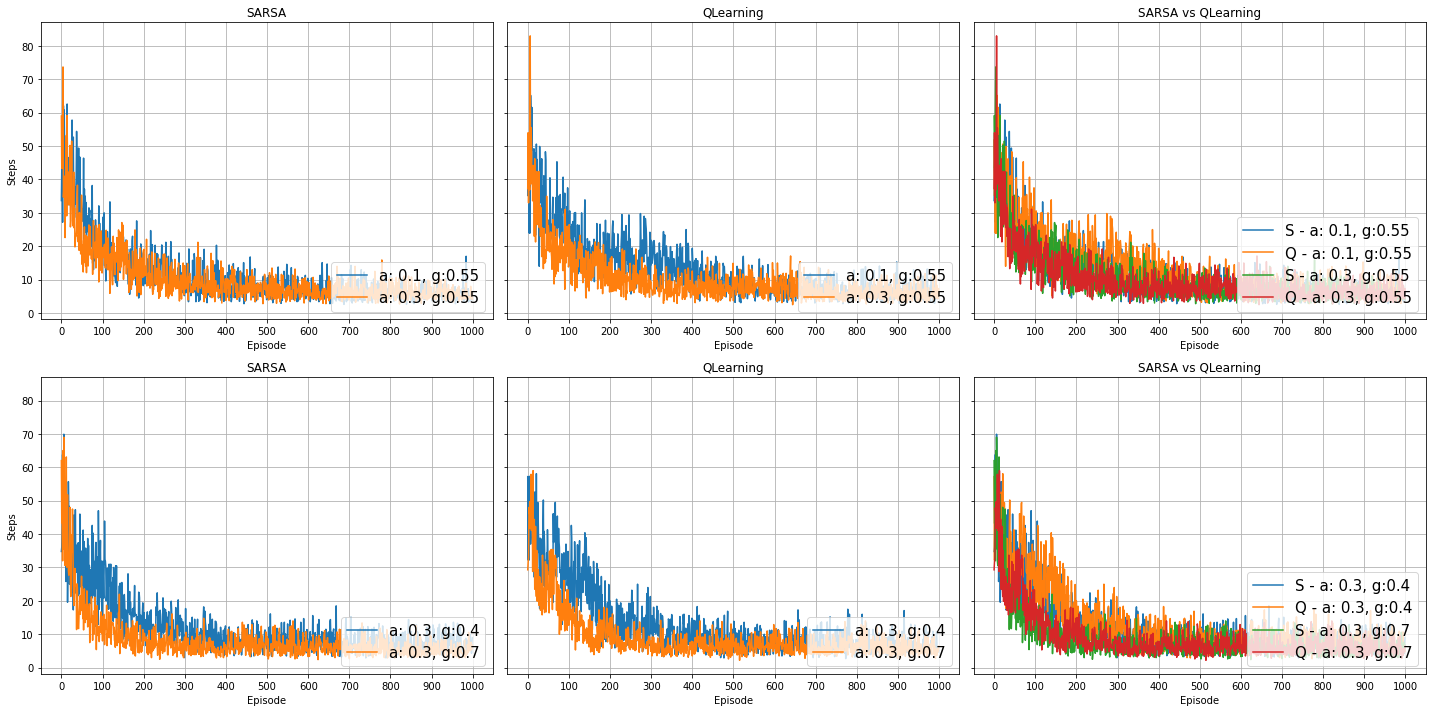

In [13]:
""" 
Plots are a comparing Q learning and Sarsa's steps per episode over multiple parameter configurations-
Experimented parameters:
- Gamma: [0.4, 0.55, 0.7]
- Alphas: [0.1, 0.2, 0.3]

"""

#chosen values      [[gammas], [Alphas]]
row_values = [[0.1,0.3,0.55], [0.3,0.4,0.7]]

#subplots
fig, ax = plt.subplots(2,3,figsize=(20,10), sharey=True)

for axis, values in zip(ax, row_values):
    plot_df = df[df.Alpha.isin(values) & df.Gamma.isin(values)]
    for i, row in plot_df.iterrows():
    #plot Sarsa
        if isinstance(row.Models, SARSAAgent):
            axis[0].plot(row.Steps, label= f"a: {row.Alpha}, g:{row.Gamma}")
            axis[0].set_title("SARSA")
    #plot QAgent
        elif isinstance(row.Models, QAgent):
            axis[1].plot(row.Steps, label= f"a: {row.Alpha}, g:{row.Gamma}")
            axis[1].set_title("QLearning")
        axis[2].plot(row.Steps, label=f"{row.Models.__class__.__name__[0]} - a: {row.Alpha}, g:{row.Gamma}")
    #plot the mix
        axis[2].set_title("SARSA vs QLearning")
        for a in axis:
            a.grid()
    #subplot designs
for axis in ax:
    for idx,a in enumerate(axis):
        if idx in [0,3]:a.set_ylabel("Steps")
        a.grid()
        start, end = a.get_xlim()
        a.xaxis.set_ticks(np.arange(start+50, end, 100))
        start, end = a.get_ylim()
        a.legend(loc= 4, prop={'size': 15})
        a.set_xlabel("Episode")

#plot
plt.tight_layout()
plt.savefig("./comparison_plots_steps_per_epi.jpg")


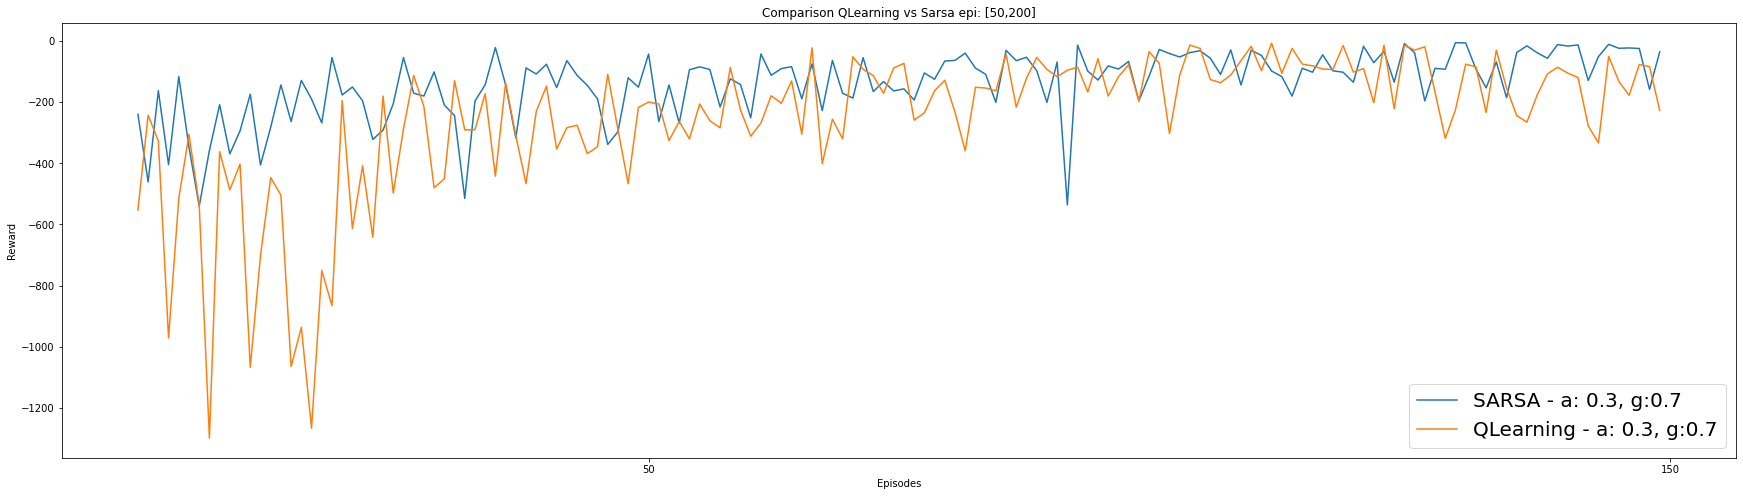

In [14]:
""" 
Plotting the reward between episode 50 to 200 in a particular config.
"""
#chosen Values
plot_df = df[(df.Alpha==0.3) & (df.Gamma==0.7)]

plt.figure(figsize=(30,8))

#plotting loop
for i, row in plot_df.iterrows():
#plot Sarsa
    if isinstance(row.Models, SARSAAgent):
        plt.plot(row.Values[50:200], label= f"SARSA - a: {row.Alpha}, g:{row.Gamma}")
#plot Sarsa
    elif isinstance(row.Models, QAgent):
        plt.plot(row.Values[50:200], label= f"QLearning - a: {row.Alpha}, g:{row.Gamma}")
#fix x-axis
start, end = plt.xlim()
plt.xticks(np.arange(50, end, 100))

#plot
plt.ylabel("Reward")
plt.xlabel("Episodes")
plt.legend(loc= 4, prop={'size': 20})
plt.title("Comparison QLearning vs Sarsa epi: [50,200]")
plt.savefig("comparison_qlearning_vs_sarsa.jpg")
plt.show()

In [15]:
# """ 
# Result Interpetation in the mentioned Interval

# output: Reward differences between Qlearning and Sarsa
# outout: The percentage Q learning is seen to be above Sarsa.
# """
# TODO: Eliminate because it changes with each execution

# #Begin Interval
# begin = 50
# end = 200

# #slice the data
# SARSA = plot_df.iloc[0].Values[begin:end]
# QLearning = plot_df.iloc[1].Values[begin:end]

# #Calculate the differences
# diff = np.mean(QLearning - SARSA)
# percentage_above = np.mean(np.where(QLearning-SARSA >0,1,0))
# print(f"Interval : {[begin, end]}")
# print(f"In the plot seen above, QLearning has a mean higher reward of {diff}\nGenerally {percentage_above*100}% of the episodes.")


Interval : [50, 200]
In the plot seen above, QLearning has a mean higher reward of -114.12266666666665
Generally 29.333333333333332% of the episodes.


In [16]:
# TODO: Eliminate because it changes with each execution
# #Begin Interval
# begin = 0
# end = -1

# SARSA = plot_df.iloc[0].Values[begin:end]
# QLearning = plot_df.iloc[1].Values[begin:end]


# #Calculate the differences
# diff = np.mean(QLearning - SARSA)
# percentage_above = np.mean(np.where(QLearning-SARSA >0,1,0))
# print(f"Interval : {[begin, end]}")
# print(f"In the total training, QLearning has a mean higher reward of {diff}\nGenerally {percentage_above*100}% of the episodes.")


Interval : [0, -1]
In the total training, QLearning has a mean higher reward of -11.76756756756757
Generally 42.34234234234234% of the episodes.


**3.2 Please interpret the results/plots (2 points)**. Explain how two algorithms differ in the learning procedure from another and what the results say about the parameters alpha (step-size) and gamma (decay-rate).

### Answer 3.2
In the following plot, we aim to show the effect of different learning parameter initializations on the reward per episode of each agent. We experimented with a wide range of values. Nontheless, for the analysis we picked the following values, because they capture the behaviour differences an interesting manner:
- alpha = [0.1, 0.2, 0.3]
- gamma = [0.4, 0.55, 0.7]

In order to illustrate how the parameters affect the outcome, we fixed one parameter and changed another in each row of the plot. The first two columns show the performance of SARSA and Q-learning configurations, respectively, while the last column shows all the plots of the latter columns together.

![](./comparison_plots_reward_per_epi.jpg)

As shown by the graphs, when any one parameter is higher, the learning seems to converge faster.

The agent learns as long as alpha is not zero.  Alpha (learning rate) represents how much weight the agent assigns to new experience. Alpha zero indicates that you wish to disregard the update, keeping the same weights during the whole training, nullifying any "learning". From the first row, we can see that the higher alpha results in a faster convergence for both agents. In the interval between 0 and 200, where the agents have not converged yet, it is evident that the higher alpha results in a greater average reward per episode.

The second row displays the effect of different gamma values, with a fixed alpha. If gamma is closer to zero, the agent will tend to consider only immediate rewards. If gamma is higher, the agent will consider future rewards with greater weight. Likewise, it is evident here that gamma affects convergence speed. The differences are more obvious at the beginning of the training. For instance, both agents' rewards are close to zero as early as episode 100, with gamma value 0.7, whereas it appears that that happens around episode 200 with gamma value 0.4. Furthermore, even when both configurations are close to convergence, it appears to perform better.

Both algorithms seem to perform similarly when run on the same configurations, making it hard to visually analyze their differences. Due to this, as seen in the plot below, we decided to zoom in on the range between episodes 50 and 200, as it seems to contain the most sifgnificant differences in reward. We chose to analyze the fastest converging configuration (alpha: 0.3, gamma: 0.7) from our experiment sample.

![](comparison_qlearning_vs_sarsa.jpg)

While it still seems do be visually difficult to choose a better performing algorithm, our intuition made us believe that QLearning had a slightly faster convergence. Thus, we calculated two parameters in order to test this assumption. These parameters are, on one hand, the percentage of the amount of time that Q-learning is above SARSA. The second parameter indicates the average reward difference between the two algorithms.

Based on our calculations, the results varied each time we ran the experiments. Thus, no certain conclusion could be obtained. The reason for this may be the number of agents we run at the same timem from which we calculate the average reward per episode. The randomness of initialization and path-choosing suggests that neither of the algorithm's consistently performs better than the other. To be able to report on this issue more accurately, we advise to run a much higher number of runs for each configuration in future work.

## Question 3.3 Code

In [17]:
""" 
Random Agent Class
A linear approximation function is used, making the computation much faster.
"""

class RandomAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        super().__init__(alpha, gamma, epsilon)
        # Use a tile coding with only a single tiling (i.e. state aggregation):
        # a grid of square tiles
        self.tile_size = 16
        self.W_SHAPE = ((Boundary.SOUTH - Boundary.NORTH + self.tile_size) // self.tile_size,
                        (Boundary.EAST - Boundary.WEST + self.tile_size) // self.tile_size, 4)
        self.w = np.zeros(self.W_SHAPE)
        
    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size,
                      action]

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return self.w[(state[1] - Boundary.NORTH) // self.tile_size, (state[0] - Boundary.WEST) // self.tile_size, :]

    # learn with given state, action and target
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        """ 
        The Ragent does not learn. Hence, values would stay as initilized
        """
        return self.select_action(next_state)

    def select_action(self, state: Tuple[int, int], is_greedy: bool = True) -> int:
        """ 
        The Ragent performs a random action. 
        """
        vals = self.values(state)
        best_actions = range(len(vals)) 
        self.hist.append(vals)

        return int(np.random.choice(best_actions))

In [18]:
# TODO: I would eliminate this
# best_agents_df = df[(df.Alpha == 0.3) & (df.Gamma == 0.7)]
# m = np.mean(best_agents_df.iloc[1].Values - best_agents_df.iloc[0].Values)
# winner = "SARSA" if m < 0 else "Q-learning"
# print(f"{winner} has a higher mean on average by {round(np.abs(m), 2)}")
# SARSA_agent = None
# Q_agent = None
# for i, row in best_agents_df.iterrows():
#     if isinstance(row.Models, SARSAAgent):
#         SARSA_agent = row.Models
#     else:
#         Q_agent = row.Models

SARSA has a higher mean on average by 11.73


In [22]:
""" 
Here we compare between the total rewards of the Random Agent, SARSA and QLearning. 
We run the experiment for 100000 rounds and all the agents are tested on the 
same starting state. 
"""

env = Environment()
epsilon = 0.0
gamma = .1
alpha = 0.3
random_agent = RandomAgent(alpha, gamma, epsilon)
random_rews=[]
sarsa_rews=[]
q_rews=[]
randoms=[]
n_its= 10000
for i in range(n_its):
    render = True if i == n_its -1 else False
# All agents start at the same state
    start_state = env.reset()
    random_end_state, random_total_reward, random_animation_data = run_episode(env, random_agent, start_state, is_learning=False, is_rendering=render)
    random_rews.append(random_total_reward)
#start for SARSA
    start_state = env.reset(start_state)
    SARSA_end_state, SARSA_total_reward, SARSA_animation_data = run_episode(env, SARSA_agent, start_state, is_learning=False, is_rendering=render)
    sarsa_rews.append(SARSA_total_reward)
#Start for Qlearning
    start_state = env.reset(start_state)
    Q_end_state, Q_total_reward, Q_animation_data = run_episode(env, Q_agent, start_state, is_learning=False, is_rendering=render)
    q_rews.append(Q_total_reward)
    print(f"\r{i+1}/{n_its}", end="")
print()

100000/100000


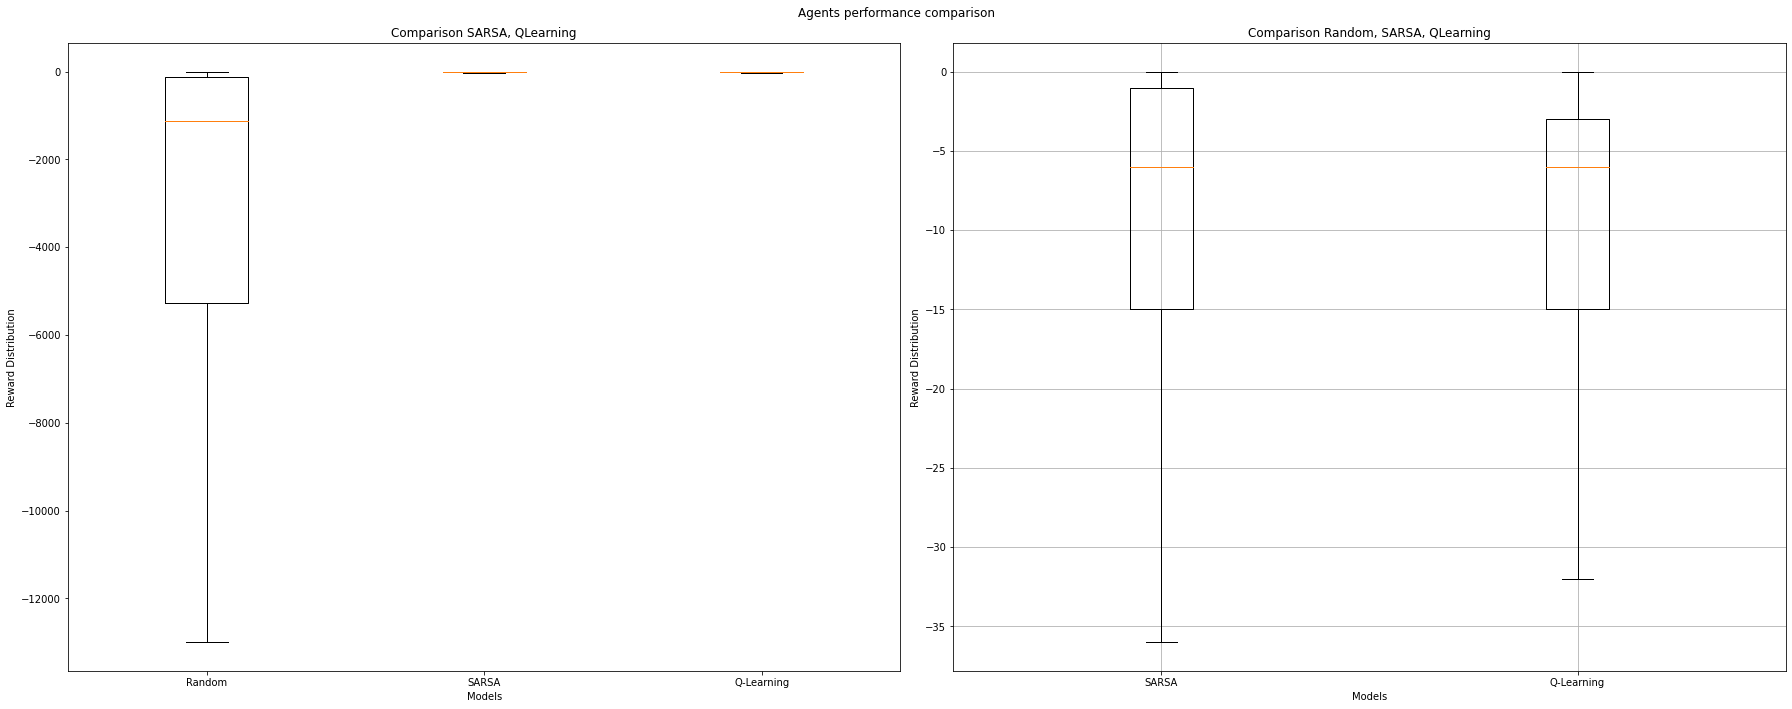

In [23]:
""" 
Plots of the distribution of the total rewards for each agent.
"""

fig, ax = plt.subplots(1,2, figsize=(25,10))
tot_rewards = [random_rews,sarsa_rews,q_rews]
ax[0].boxplot(tot_rewards, showfliers=False)
ax[0].set_xticklabels(['Random', 'SARSA', 'Q-Learning'])
ax[0].margins(y=0.05)
ax[0].set_title("Comparison SARSA, QLearning")
ax[0].set_xlabel("Models")
ax[0].set_ylabel("Reward Distribution")


ax[1].boxplot(tot_rewards[1:], showfliers=False)
ax[1].set_xticklabels(['SARSA', 'Q-Learning'])
ax[1].set_title("Comparison Random, SARSA, QLearning")
ax[1].set_xlabel("Models")
ax[1].set_ylabel("Reward Distribution")

fig.suptitle("Agents performance comparison")

#Plots
plt.grid()

plt.savefig("./agents_performance_comparison.jpg")
plt.tight_layout()


In [21]:
# """ 
# Plots of Agent-State values for Better Visualiztion
# """
# TODO: I would remove this too, as we don't really talk about it and i can't really think of anything to say about it.

# stride=1
# fig, ax = plt.subplots(1,3, figsize=(25,10))
# agents = ["random_agent","SARSA_agent" ,"Q_agent"]
# idx = 0
# for axis, agent in zip(ax, [random_agent,SARSA_agent ,Q_agent]):
#     agent.v = np.zeros(
#         ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
#     for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
#         for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
#             agent.v[i, j] = agent.state_value((x, y))

#     axis.imshow(agent.v)
#     axis.set_title(f"State Value {str(agents[idx])}")
#     axis.set_xlabel("X Grid ")
#     axis.set_ylabel(f"Y Grid ")
#     idx+=1


# fig.suptitle("Agents state_values")

# plt.savefig("agents_state_values.jpg")
# plt.tight_layout()
# plt.show()



**3.3 Let think one step further by looking at the policies you have learned (1.5 points).** 

Please compare the performance of your learned optimal policies using another simulation. In this simulation, you shall have three agents (Qlearning_Agent, SARSA_agent and Random_agent), where all three agents always use their initial policy to behave and find the goal in the given map (make sure the agent does NOT learn anymore!). The initial policies of Qlearning_Agent and SARSA_agent are the optimal policies learned from the above experiments (based on the final estimated Q-values using Q-learning and SARSA algorithm respectively). The inital policy of Random_Agent will select 4 actions randomly. There is no need to submit your codes for this question.

Describe the performance of three agents by running each agent on the task and discuss the results (1.5 points). You can use the render function provided above (and other helper functions) observe the different behaviors of three agents. You could also use an appropriate plot to show the different performances. 

Some questions you shall think about and answer (in case there are no differences or no special things, just indicate what you observed):
- How does the learned Q-learning policy and SARSA policy perform differently? Does it show the difference between on-policy and off-policy methods?
- What kind of strategy did the two RL agents learn similarly? How do they differ from the random policy?
- For the RL-learned policies, do you still observe something that does not perform so well? Can you think about possible ways to improve/solve it?

## Question 3.3 Answer
In order to evaluate the performance differences between the Random, SARSA, and Qlearning agents, we first examined the best performing agents in the previous experiment. The selected values for this experiment were gamma = 0.7 and alpha = 0.3. We chose these values because they were also selected for our previous analysis (Question 3.2).

![](agents_performance_comparison.jpg)

The boxplots clearly show that the random agent has a considerably worse reward distribution than the SARSA and Q-learning agents. When comparing the distribution of the three models, an interesting observation can be made. Both RL-learned agents have a similar standard deviation and mean. The random agent's expected rewards are much lower, reaching a mean of close to -2000 units. In the current grid, the reward is always negative, so the longer the agent stays on the grid, the lower its reward will be, which is expected, as the random agent will move around aimlessly on the grid, accumulating a lot of negative reward. At the same time, it is observed that some of the episodes have a zero reward, which means that they start out at the goal state.

Since we failed to observe a significant difference in our previous analysis, we decided to compare the reward distribution between Qlearning and SARSA separately from the random agent. Nontheless, here too, we observe that both models show very similar behavior, where the expected reward of Qlearning is slightly higher than the observed reward of SARSA depending on every different run of the test. 

Q-learning, in general finds a more risky path than SARSA, but with higher reward. Nontheless, in this test, since there is no significant negative reward at a particular state in our current grid, it suggests that both models will behave similarly, as is shown. Q-learning updates its weights only with the highest observed state action pair, while SARSA, an on-policy Agent, updates its value based on the same epsilon-greedy algorithm it uses to dictate its behavior.

The behavior that both SARSA and the Q-learning algorithms learn is to find the optimal path to the goal state, given the current environment. As the current context gives only negative rewards for every step, and a major penalty for a timeout, both typs of agents strive to find the fastest path to the goal. Moreover, this is a convenient setup as it enables a high degree of exploration, apart from the exploration already provided by the epsilon-greedy policy. This is both because the action-values (in this case, the weights) are initialized with 0 and because all rewards are negative. Any path will leave a trail of negative rewards in the weights corresponding to the states it has visited. This means that the epsilon greedy algorithm will choose a new path every time there is one available (because it's value will be 0, i.e., the highest) when it behaves greedily. 

The graph below is similar to the graph in Answer 3.2., but here it shows the average steps per episode instead of the reward. The main thing to observe is that with any of the configurations, the agent's will learn to take as few steps as possible towards the goal. Meanwhile, the random agent has no way to update its weights and to learn a quick path, so the amount of steps it takes to reach the goal will be random too.

![](comparison_plots_steps_per_epi.jpg)


From the RL-learned policies, something that affects performance at execution time, after training, is the variance in mean reward obtained. This is because the agents can take an incredibly high number of different paths while training, and thus each weight may be learned a different amount of times, inducing some errors, due to the values being further away from the optimal ones. This can be handled by running the agent several times with the same configuration and averaging the weight matrices, as the Law of Large Numbers suggests that this will give a better estimate of the global expected action-values.

You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.**

Again, make your you name this file according to your last names.